## Homework

### Dataset

In this homework, we will use the California Housing Prices. You can take it from
[Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices).

The goal of this homework is to create a regression model for predicting housing prices (column `'median_house_value'`).

### EDA

* Load the data.
* Look at the `median_house_value` variable. Does it have a long tail? 

### Features

For the rest of the homework, you'll need to use only these columns:

* `'latitude'`,
* `'longitude'`,
* `'housing_median_age'`,
* `'total_rooms'`,
* `'total_bedrooms'`,
* `'population'`,
* `'households'`,
* `'median_income'`,
* `'median_house_value'`

Select only them.

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
df=pd.read_csv("housing.csv")[['latitude','longitude','housing_median_age','total_rooms','total_bedrooms','population','households','median_income','median_house_value']]

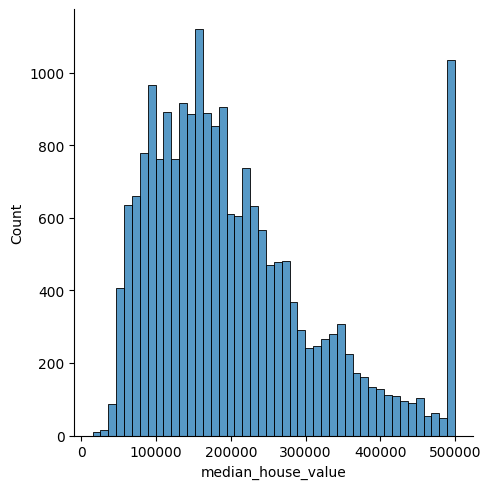

In [35]:
sns.displot(df["median_house_value"])
plt.show()

### Question 1

Find a feature with missing values. How many missing values does it have?
- 207
- 307
- 408
- 508

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   latitude            20640 non-null  float64
 1   longitude           20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


So `total_bedrooms`is the one that has null values and it has a total of
$$20640-20433= 207$$
null values.

### Question 2

What's the median (50% percentile) for variable 'population'?
- 1133
- 1122
- 1166
- 1188


In [37]:
df["population"].median()

1166.0

### Split the data

* Shuffle the initial dataset, use seed `42`.
* Split your data in train/val/test sets, with 60%/20%/20% distribution.
* Make sure that the target value ('median_house_value') is not in your dataframe.
* Apply the log transformation to the median_house_value variable using the `np.log1p()` function.

In [38]:
np.random.seed(42)

n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

y_train_orig = df_train.median_house_value.values
y_val_orig = df_val.median_house_value.values
y_test_orig = df_test.median_house_value.values
#
y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)
#
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

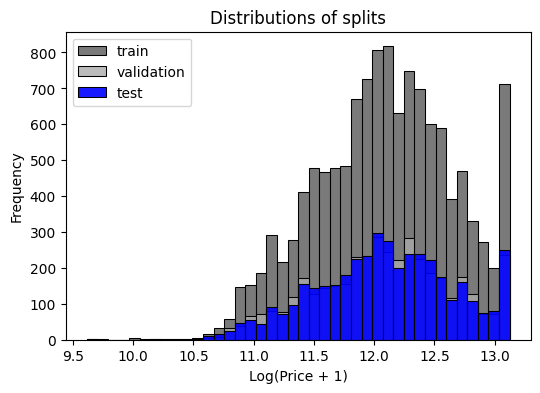

In [27]:
plt.figure(figsize=(6, 4))

sns.histplot(y_train, label='train', color='#222222', alpha=0.6, bins=40)
sns.histplot(y_val, label='validation', color='#aaaaaa', alpha=0.8, bins=40)
sns.histplot(y_test, label = "test",color="blue",alpha=0.9,bins=40)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Distributions of splits')

plt.show()

### Question 3

* We need to deal with missing values for the column from Q1.
* We have two options: fill it with 0 or with the mean of this variable.
* Try both options. For each, train a linear regression model without regularization using the code from the lessons.
* For computing the mean, use the training only!
* Use the validation dataset to evaluate the models and compare the RMSE of each option.
* Round the RMSE scores to 2 decimal digits using `round(score, 2)`
* Which option gives better RMSE?

In [43]:
base=['latitude','longitude','housing_median_age','total_rooms','total_bedrooms','population','households','median_income']
def prepare_X(df,fill_value):
    df = df[base].copy()
    X = df.fillna(fill_value).values
    return X

def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.round(np.sqrt(mse),2)

#fill with zero
X_train=prepare_X(df_train,0)
w_0, w = train_linear_regression(X_train, y_train)
y_pred = w_0 + X_train.dot(w)
print('train with fill 0:', rmse(y_train, y_pred))
X_val = prepare_X(df_val,0)
y_pred = w_0 + X_val.dot(w)
print('validation with fill 0:', rmse(y_val, y_pred))

#fill with mean
X_train=prepare_X(df_train,df_train["total_bedrooms"].mean())
w_0, w = train_linear_regression(X_train, y_train)
y_pred = w_0 + X_train.dot(w)
print('train with fill mean:', rmse(y_train, y_pred))
X_val = prepare_X(df_val,df_train["total_bedrooms"].mean())
y_pred = w_0 + X_val.dot(w)
print('validation with fill mean:', rmse(y_val, y_pred))

train with fill 0: 0.34
validation with fill 0: 0.33
train with fill mean: 0.34
validation with fill mean: 0.33


So both are equally good

### Question 4

* Now let's train a regularized linear regression.
* For this question, fill the NAs with 0. 
* Try different values of `r` from this list: `[0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]`.
* Use RMSE to evaluate the model on the validation dataset.
* Round the RMSE scores to 2 decimal digits.
* Which `r` gives the best RMSE?

If there are multiple options, select the smallest `r`.

Options:
- 0
- 0.000001
- 0.001
- 0.0001

In [49]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

X_train = prepare_X(df_train,0)
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_train.dot(w)
    #print('train', rmse(y_train, y_pred),"r=",r)
    X_val = prepare_X(df_val,0)
    y_pred = w_0 + X_val.dot(w)
    #print('val', rmse(y_val, y_pred),"r=",r)
    #print("--"*20)
    if rmse(y_val, y_pred) ==0.33:
        print(r)

0
1e-06
0.0001
0.001
0.01
0.1
1


### Question 5 

* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores. 
* What's the standard deviation of all the scores? To compute the standard deviation, use `np.std`.
* Round the result to 3 decimal digits (`round(std, 3)`)

> Note: Standard deviation shows how different the values are.
> If it's low, then all values are approximately the same.
> If it's high, the values are different. 
> If standard deviation of scores is low, then our model is *stable*.

Options:
- 0.16
- 0.00005
- 0.005
- 0.15555

In [50]:
def split_data(df,seed):
    np.random.seed(seed)

    n = len(df)

    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)

    idx = np.arange(n)
    np.random.shuffle(idx)

    df_shuffled = df.iloc[idx]

    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()

    y_train_orig = df_train.median_house_value.values
    y_val_orig = df_val.median_house_value.values
    y_test_orig = df_test.median_house_value.values
    #
    y_train = np.log1p(df_train.median_house_value.values)
    y_val = np.log1p(df_val.median_house_value.values)
    y_test = np.log1p(df_test.median_house_value.values)
    #
    del df_train['median_house_value']
    del df_val['median_house_value']
    del df_test['median_house_value']
    return df_train,y_train, df_val,y_val, df_test, y_test

In [52]:
results=[]
for i in range(10):
    df_train,y_train, df_val,y_val, df_test, y_test=split_data(df,i)
    X_train=prepare_X(df_train,0)
    w_0, w = train_linear_regression(X_train, y_train)
    X_val = prepare_X(df_val,0)
    y_pred = w_0 + X_val.dot(w)
    results.append(rmse(y_val, y_pred))

In [54]:
np.round(np.std(results),3)

0.005

In [57]:
np.mean(results)/(np.mean(results)+3*np.std(results)),np.mean(results)/(np.mean(results)-3*np.std(results))

(0.9547662161894623, 1.049733008082215)

In [59]:
np.std(results)/np.mean(results)

0.015792272161684724

### Question 6

* Split the dataset like previously, use seed 9.
* Combine train and validation datasets.
* Fill the missing values with 0 and train a model with `r=0.001`. 
* What's the RMSE on the test dataset?

Options:
- 0.35
- 0.135
- 0.450
- 0.245

In [66]:
df_train,y_train, df_val,y_val, df_test, y_test=split_data(df,9)
X_train=prepare_X(pd.concat([df_train,df_val]),0)
y_train=np.append(y_train,y_val)
w_0, w = train_linear_regression_reg(X_train, y_train,r=0.001)
X_test = prepare_X(df_test,0)
y_pred = w_0 + X_test.dot(w)
print(rmse(y_test, y_pred))

0.35


## Submit the results
- Submit your results here: https://forms.gle/WCVb4KMNsgbkuJtr6
- If your answer doesn't match options exactly, select the closest one.
- You can submit your solution multiple times. In this case, only the last submission will be used

## Deadline

The deadline for submitting is, 19 September 2022, 23:00 CET. After that, the form will be closed.